In [1]:
import findspark
findspark.init()

import pyspark
import pyspark.sql
from pyspark.sql import *
import os.path
from pyspark.sql.functions import desc

from pyspark.sql import dataframe
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
import seaborn as sns
import re
import pandas as pd

In [7]:
DATA_DIR = '../../data/data_processed/'

In [8]:
conflicts = spark.read.parquet(DATA_DIR+"union_3_cat.parquet")

In [9]:
conflicts.printSchema()

root
 |-- id: long (nullable = true)
 |-- title: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- article_lenght: integer (nullable = true)
 |-- views: long (nullable = true)
 |-- refs_count: long (nullable = true)
 |-- link_count: long (nullable = true)
 |-- death: string (nullable = true)
 |-- end_date: string (nullable = true)
 |-- location: string (nullable = true)



In [5]:
conflicts.select("id","death","end_date","location").show()

+--------+--------------------+--------------------+--------------------+
|      id|               death|            end_date|            location|
+--------+--------------------+--------------------+--------------------+
|50429564|            33+ (+2)|          1 May 2016|   Samawah (Q750679)|
|39900222|                   4|         22 May 2013|Zatloukalova 404/...|
|46935886|                   4|   December 14, 1993|12293 East Iliff ...|
|38247068|At least 67 (at l...|                null|West of [[In Amen...|
|19896366|                  17|     21 October 2008|    Imphal (Q208097)|
| 2234230|8 civilian hostag...|+1975-03-05T00:00...|   Tel Aviv (Q33935)|
| 4538300|                  97|         27 May 1940|Le Paradis villag...|
|12983993|                   3|   September 3, 1984|[[Montreal]], [[Q...|
|10032978| 1 (one perpetrator)|      March 11, 2007|  Casablanca (Q7903)|
|41583832|                 983|{{start date and ...|                null|
|52461344|                  69|     16

In [6]:
# Quantifying null values
# how many rows does the dataframe have?
nConflict=conflicts.count()

conflict_nan = conflicts.select([
    count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in conflicts.columns
]).select("id","death","end_date","location").toPandas()

conflict_percentages_nan = conflict_nan*100/nConflict
conflict_percentages_nan.head()

,id,death,end_date,location
0,0.0,34.331349,12.411266,11.088848


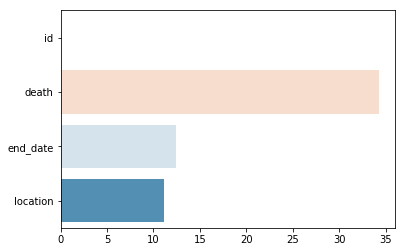

In [7]:
sns.barplot(data=conflict_percentages_nan, palette='RdBu',orient='h')

In [10]:
deaths_pd = conflicts.select("id","title","death").toPandas().set_index('id').fillna(0)

In [9]:
deaths_pd['n_death'] = 0

In [28]:
def extract_deaths(_raw_str):    
    raw_str = re.sub(r'{.*?}','',str(_raw_str)) # questo è estremo, ne abbiamo veramente bisogno?
    raw_str = re.sub(r'isbn=\d{1,99}|{isbn[|]\d.*?}', '', raw_str)
    raw_str = re.sub(r"(?:(?:https?|ftp):\/\/|\b(?:[a-z\d]+\.))(?:(?:[^\s()<>]+|\((?:[^\s()<>]+|(?:\([^\s()<>]+\)))?\))+(?:\((?:[^\s()<>]+|(?:\(?:[^\s()<>]+\)))?\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))?", '', raw_str)
    raw_str = re.sub(r"\|\d{1,9}\||\|\d{1,9}\.\d{1,9}em\||\d{1,9}\.\d{1,9}em\||page.\d{1,9}|p\..\d{1,9}",'',raw_str)
    raw_str = raw_str.replace(".",",")
    regex_nbrs = re.compile(r"\d{1,9}((,|')\d{3})*(\.\d+)?")
    regex_rngs = re.compile(r"\d{1,9}((,|')\d{3})(.\d+)?([-–]| to | [-–] )\d{1,9}((,|')\d{3})([,']\d+)?")
    allExtr = [];
    
    if(raw_str == 0):
        return 0;
    for match in regex_nbrs.finditer(raw_str):
        allExtr.append(match.group(0))
        
    if(len(allExtr) < 1):
        return 0
        
    rng1 = -1
    rng2 = -1
    for match in regex_rngs.finditer(raw_str):
        rng = match.group(0)
        rng_split = (rng.replace(',','')
                        .replace("'","")
                        .replace("–","-")
                        .replace(" - ","-")
                        .replace(" to ","-").split("-"))
        rng1 = int(rng_split[0])
        rng2 = int(rng_split[1])
        if(rng1>=rng2):
            continue
            
        rng_sum = str(int((int(rng_split[0])+int(rng_split[1]))/2));
        allExtr.append(rng_sum)
        
    #cleaning: 
    #allExtr = [ x for x in allExtr if "." not in x ]
    allExtr = [extr.replace(',', '').replace("'","") for extr in allExtr]
    allExtr = [int(i) for i in allExtr]
    allExtr = [ x for x in allExtr if x not in [rng1,rng2] ]
    
    if(len(allExtr) == 1):
        return allExtr[0]
    
    def shouldGetMax(raw_str,lenExtr):
        toExclude = re.compile(r"(at least|total|over [0-9])",re.IGNORECASE)
        if(toExclude.search(raw_str)):
            return True
        if(lenExtr >=5): #5 numero arbitrario
            return True
        return False
    
    if shouldGetMax(raw_str, len(allExtr)):
        return max(allExtr)
    
    return sum(i for i in allExtr)

In [29]:
deaths_pd["n_death"] = deaths_pd["death"].apply(extract_deaths)

In [30]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 50)
deaths_pd[deaths_pd["n_death"] != 0].sort_values(by=['n_death'],ascending=False)

,title,death,n_death
id,,,
32927,World War II,+73000000,73000000
342641,Pacific War,"{{ublist\n | '''Military'''<br />4,000,000+ d...",26000000
4764461,World War I,+17000000,17000000
52166101,Mass killings of landlords under Mao Zedong,"4,500,000 (from 1947 –1951)<br>\n13,500,000 to...",13875000
69980,Second Sino-Japanese War,{{plainlist|\n* '''Chinese Nationalists''':\n*...,10600000
1120226,Japanese war crimes,"3,000,000 to 14,000,000 civilians and P.O.W.s",8500000
35053080,"Western Front tactics, 1917","7,947,000",7947000
51499,Western Front (World War I),{{ubl|'''Military casualties:'''}} {{clist|bul...,7500000
1014346,Eastern Front (World War I),"{{ubl|flagdeco|German Empire| '''1,468,811 – 2...",6500000


C:\Users\Pietro\AppData\Local\conda\conda\envs\ada\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


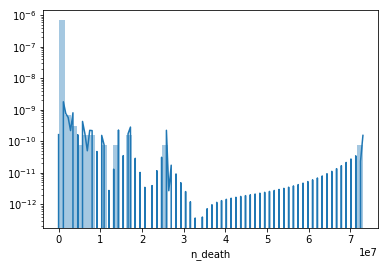

In [17]:
ax = sns.distplot(deaths_pd[deaths_pd["n_death"] != 0]['n_death']);
ax.set_yscale('log')